$$\textrm{Joaquin Peñuela Parra, Cristian Fernando Rodriguez Cruz}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

In [1]:
import os
from itertools import product
import pandas as pd
import multiprocessing as mp

In [2]:
import subprocess

## IMPORTANT: Make sure that "Uniandes_Framework" is in .gitignore
framework_path = "Uniandes_Framework"

if os.path.exists(framework_path):
    # Pull updates if the framework is already cloned
    try:
        subprocess.run(["git", "-C", framework_path, "pull"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while pulling updates from the framework: {e}")
else:
    # Clone the framework if it is not already cloned
    try:
        subprocess.run(["git", "clone", "git@github.com:Phenomenology-group-uniandes/Uniandes_Framework.git"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while cloning the framework: {e}")
from Uniandes_Framework.delphes_reader.lhereader import LHE_Loader, readLHEF, get_event_by_child
from Uniandes_Framework.delphes_reader.root_analysis import get_kinematics_row, make_histograms, overlap_histos, Quiet

hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.


Already up to date.
Welcome to JupyROOT 6.22/06


In [3]:
case = "woRHC"
# case = "wRHC"

limit = 'zp_upper_limit'
# limit = 'zp_lower_limit'

In [4]:
sim_path = os.path.join(os.sep, 'disco4', 'personal_folders', 'Cristian', 'SIMULATIONS', 'lq_zp', case, limit)

signals = ["non-res_tau_tau",
           # "zp_tau_tau"
          ]

M_U= [1000]
G_U = [1.75]
G_ZP = [1.25, 1.5]

csv_sim_path = pd.read_csv(os.path.join("Uniandes_Framework", "SimulationsPaths.csv"))

#xs_path = { signal: os.path.join( os.path.dirname(os.getcwd()), "01_signal_production", f"xs_signals_{case}", signal, "XS_Matrix.csv") for signal in signals}

df = pd.concat(
    [csv_sim_path]
    +
    [ pd.DataFrame.from_dict(
    {
        "name": f"{case}_{limit}_" + signal + f"_mu_{m}_gu{gu}_gzp_{gzp}".replace('.', '_'), 
        "path": os.path.join(sim_path, signal,f'mu_{m}_gu{gu}_gzp_{gzp}'.replace('.', '_')),  
        'xs(pb)': 1.0
    }, 
    orient = "index").T for signal, m , gu, gzp in product(signals,M_U,G_U, G_ZP) ]
)

# save the new csv
csv_sim_path = os.path.join(os.getcwd(), "SimulationsPaths.csv")
df.to_csv(csv_sim_path, index = False)

In [5]:
def get_kinematics(run):
    run_name = os.path.basename(os.path.dirname(run))
    childs=readLHEF(run)
    if os.path.isfile(run):
        print('Reading', run_name)
    else:
        pass
    
    results = list()
    for child in childs:
        event = get_event_by_child(child)
        taus = event.getParticlesByIDs([-15,15])
        if len(taus) == 2:
            taus[0].SetName("#tau_{1}")
            taus[1].SetName("#tau_{2}")
            sum_taus = taus[0].TLV + taus[1].TLV
        else :
            continue
        row = get_kinematics_row(taus)
        row["m_ll(GeV)"] = sum_taus.M()
        row["sT(GeV)"] = row["pT_{#tau_{1}}(GeV)"] + row["pT_{#tau_{2}}(GeV)"]
        
        results.append(row)
    print(run_name, 'done!')
    return results


In [6]:
# Load the simulation

def load_simulation(x):
    signal, m, gu, gzp = x
    signal_key = f"{case}_{limit}_" + signal + f"_mu_{m}_gu{gu}_gzp_{gzp}".replace('.', '_')
    
    lhe_loader = LHE_Loader(signal_key, csv_sim_path)
    results = list()
    
    n_cores = 3
    with mp.Pool(n_cores) as pool:
        for result in list(pool.map(get_kinematics, lhe_loader.Forest)):
            results += result
    return signal_key, pd.DataFrame.from_records(results)

In [7]:
a = dict(map(load_simulation, product(signals,M_U,G_U, G_ZP)))

woRHC_zp_upper_limit_non-res_tau_tau_mu_1000_gu1_75_gzp_1_25 imported with 1 trees!
/disco4/personal_folders/Cristian/SIMULATIONS/lq_zp/woRHC/zp_upper_limit/non-res_tau_tau/mu_1000_gu1_75_gzp_1_25
Reading run_01
run_01 done!
woRHC_zp_upper_limit_non-res_tau_tau_mu_1000_gu1_75_gzp_1_5 imported with 1 trees!
/disco4/personal_folders/Cristian/SIMULATIONS/lq_zp/woRHC/zp_upper_limit/non-res_tau_tau/mu_1000_gu1_75_gzp_1_5
Reading run_01
run_01 done!


In [8]:
a.keys()

dict_keys(['woRHC_zp_upper_limit_non-res_tau_tau_mu_1000_gu1_75_gzp_1_25', 'woRHC_zp_upper_limit_non-res_tau_tau_mu_1000_gu1_75_gzp_1_5'])

In [9]:
a['woRHC_zp_upper_limit_non-res_tau_tau_mu_1000_gu1_75_gzp_1_25'].head()

,pT_{#tau_{1}}(GeV),#eta_{#tau_{1}},#phi_{#tau_{1}},Energy_{#tau_{1}}(GeV),Mass_{#tau_{1}}(GeV)),#Delta{R}_{#tau_{1}#tau_{2}},#Delta{#eta}_{#tau_{1}#tau_{2}},#Delta{#phi}_{#tau_{1}#tau_{2}},#Delta{pT}_{#tau_{1}#tau_{2}}(GeV),#Delta{#vec{pT}}_{#tau_{1}#tau_{2}}(GeV),#Delta{#vec{p}}_{#tau_{1}#tau_{2}}(GeV),pT_{#tau_{2}}(GeV),#eta_{#tau_{2}},#phi_{#tau_{2}},Energy_{#tau_{2}}(GeV),Mass_{#tau_{2}}(GeV)),m_ll(GeV),sT(GeV)
0,72.364782,2.107338,0.628037,302.045935,0.002163,3.697778,1.950375,3.141593,0.0,144.729565,316.832186,72.364782,0.156963,-2.513556,73.258052,0.000293,219.177413,144.729565
1,171.761324,-2.376154,2.804024,932.348848,-0.001387,3.333441,-1.114551,3.141593,0.0,343.522649,724.130280,171.761324,-1.261603,-0.337569,327.572498,-0.002258,398.258998,343.522649
2,116.749544,-0.245187,0.118670,120.276442,0.000887,3.373193,-1.228343,3.141593,0.0,233.499087,284.823042,116.749544,0.983157,-3.022923,177.868449,-0.000244,278.939645,233.499087
3,278.938110,1.368815,2.251413,583.691834,0.002083,3.695927,1.946863,3.141593,0.0,557.876219,881.957211,278.938110,-0.578048,-0.890180,326.852340,0.001829,843.730998,557.876219
4,126.216139,-0.894345,2.514940,180.148827,0.000533,4.124508,-2.672444,3.141593,0.0,252.432279,552.437235,126.216139,1.778099,-0.626653,384.173915,-0.000900,513.381595,252.432279


In [10]:
default_hist_bins_dict={
    "#Delta{R}":[96,0,7],
    "#Delta{#eta}":[80,-5,5],
    "#Delta{#phi}":[52,-3.25,3.25],
    "#Delta{pT}":[120, 0.0, 1500.0],
    "#Delta{#vec{pT}}":[240, 0.0, 4800.0],
    "#Delta{#vec{p}}":[240, 0.0, 4800.0],
    "MET(GeV)":[80, 0.0, 1000.0],
    "pT_": [160, 0.0, 2000.0],
    "sT(GeV)": [200, 0.0, 4000.0],
    "mT(GeV)": [200, 0.0, 4000.0],
    "#eta_":[80, -5, 5],
    "#phi_":[128, -3.2, 3.2],
    "Energy_":[80, 0.0, 1000.0],
    "m_ll(GeV)" : [160, 0.0, 2000.0]
}

In [11]:
root_histos = {'wRHC': {'zp_upper_limit': {}, 'zp_lower_limit': {}},
               'woRHC': {'zp_upper_limit': {}, 'zp_lower_limit': {}}}

for key in a.keys():
    Betard = key.split('_')[0]
    ZP_Limit = 'zp_' + key.split('_')[2] + '_limit'
    m_gu_gz = "mu" + key.split('mu')[1]
    signal = ''.join(key.split('_')[4: len(key.split('_')) - 7]).replace('tau', ' #tau').replace('mu', ' mu')
    
    root_histos[Betard][ZP_Limit][m_gu_gz] = {}
    root_histos[Betard][ZP_Limit][m_gu_gz][signal] = make_histograms(a[key],hist_bins_dict = default_hist_bins_dict)

In [12]:
root_histos[Betard][ZP_Limit][m_gu_gz]

{'non-res #tau #tau': {'pT_{#tau_{1}}(GeV)': <cppyy.gbl.TH1F object at 0x55aa6b130b90>,
  '#eta_{#tau_{1}}': <cppyy.gbl.TH1F object at 0x55aa6b908900>,
  '#phi_{#tau_{1}}': <cppyy.gbl.TH1F object at 0x55aa6b908da0>,
  'Energy_{#tau_{1}}(GeV)': <cppyy.gbl.TH1F object at 0x55aa6b91d600>,
  '#Delta{R}_{#tau_{1}#tau_{2}}': <cppyy.gbl.TH1F object at 0x55aa6b9434f0>,
  '#Delta{#eta}_{#tau_{1}#tau_{2}}': <cppyy.gbl.TH1F object at 0x55aa6b9439d0>,
  '#Delta{#phi}_{#tau_{1}#tau_{2}}': <cppyy.gbl.TH1F object at 0x55aa6b944000>,
  '#Delta{pT}_{#tau_{1}#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55aa6b9444e0>,
  '#Delta{#vec{pT}}_{#tau_{1}#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55aa6b8e7a20>,
  '#Delta{#vec{p}}_{#tau_{1}#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55aa6b8e8620>,
  'pT_{#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55aa6b1051e0>,
  '#eta_{#tau_{2}}': <cppyy.gbl.TH1F object at 0x55aa6b901a60>,
  '#phi_{#tau_{2}}': <cppyy.gbl.TH1F object at 0x55aa6b902050>,
  'Energy_{#tau_{2}}(

In [13]:
# !rm -rf Most_Important_Kinematic_Histograms/

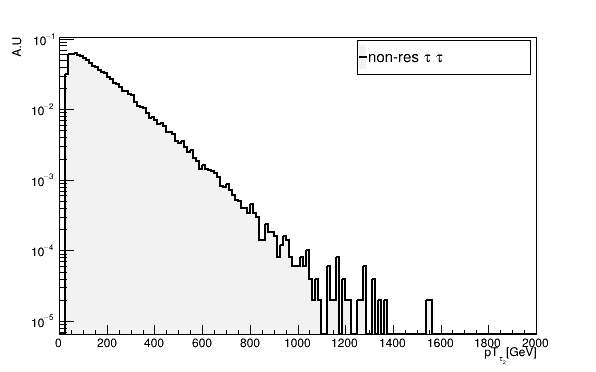

In [14]:
Important_features = ['m_ll(GeV)', 'sT(GeV)','#Delta{R}_{#tau_{1}#tau_{2}}', '#Delta{#phi}_{#tau_{1}#tau_{2}}', '#phi_{#tau_{1}}', '#eta_{#tau_{1}}', '#phi_{#tau_{2}}', 
                      '#Delta{pT}_{#tau_{1}#tau_{2}}(GeV)', '#Delta{#vec{pT}}_{#tau_{1}#tau_{2}}(GeV)', 'pT_{#tau_{1}}(GeV)', 'pT_{#tau_{2}}(GeV)']

folder = 'Most_Important_Kinematic_Histograms'
os.makedirs(folder, exist_ok=True)

for Betard in root_histos.keys():
    for ZP_Limit in root_histos[Betard].keys():
        for m_gu_gz in root_histos[Betard][ZP_Limit].keys():
            os.makedirs(os.path.join(folder, Betard, ZP_Limit, m_gu_gz), exist_ok=True)
            
            for feature in Important_features:
                histos, canvas, legend = overlap_histos(feature, root_histos[Betard][ZP_Limit][m_gu_gz], log_scale =True)
                with Quiet(): canvas.SaveAs(os.path.join(folder, Betard, ZP_Limit, m_gu_gz, f"{feature}.pdf".replace('{', '').replace('}', '')))